<a href="https://colab.research.google.com/github/amadousysada/image-segmentation/blob/main/p8_01_exploration_and_features_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Import des librairies

In [77]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt

print("Versions:")
print(f"{' '*2}- Pandas       =>: {pd.__version__}")
print(f"{' '*2}- Numpy        =>: {np.__version__}")
print(f"{' '*2}- tensorflow   =>: {tf.__version__}")
print(f"{' '*2}- keras        =>: {tf.keras.__version__}")
print(f"{' '*2}- matplotlib   =>: {plt.matplotlib.__version__}")

Versions:
  - Pandas       =>: 2.2.2
  - Numpy        =>: 2.0.2
  - tensorflow   =>: 2.18.0
  - keras        =>: 3.8.0
  - matplotlib   =>: 3.10.0


In [76]:
base_path = "/content/drive/MyDrive/data/"
image_dir = os.path.join(base_path, "leftImg8bit")
mask_dir = os.path.join(base_path, "gtFine")

In [136]:
# Mapping des groupes vers la liste des classes Cityscapes correspondantes
CLASS_GROUPS = {
    "flat":        ["road", "sidewalk", "parking", "rail track"],
    "human":       ["person", "rider"],
    "vehicle":     ["car", "truck", "bus", "on rails", "motorcycle", "bicycle", "caravan", "trailer"],
    "construction":["building", "wall", "fence", "guard rail", "bridge", "tunnel"],
    "object":      ["pole", "pole group", "traffic sign", "traffic light"],
    "nature":      ["vegetation", "terrain"],
    "sky":         ["sky"],
    "void":        ["unlabeled", "ego vehicle", "ground", "rectification border", "out of roi", "dynamic", "static"]
}



ordered_groups = list(CLASS_GROUPS.keys())

LABEL_ID_TO_NAME = {
    0: "unlabeled",
    1: "ego vehicle",
    2: "rectification border",
    3: "out of roi",
    4: "static",
    5: "dynamic",
    6: "ground",
    7: "road",
    8: "sidewalk",
    9: "parking",
    10: "rail track",
    11: "building",
    12: "wall",
    13: "fence",
    14: "guard rail",
    15: "bridge",
    16: "tunnel",
    17: "pole",
    18: "pole group",
    19: "traffic light",
    20: "traffic sign",
    21: "vegetation",
    22: "terrain",
    23: "sky",
    24: "person",
    25: "rider",
    26: "car",
    27: "truck",
    28: "bus",
    29: "caravan",
    30: "trailer",
    31: "on rails",
    32: "motorcycle",
    33: "bicycle",
}

NAME_TO_LABEL_ID = {v: k for k, v in sorted(LABEL_ID_TO_NAME.items())}

CLASS_MAP = {}
for group_idx, group_name in enumerate(ordered_groups):
    for class_name in CLASS_GROUPS[group_name]:
        cid = NAME_TO_LABEL_ID.get(class_name, -1)
        CLASS_MAP[cid] = group_idx
print(CLASS_MAP)


mapping = [7] * 34   # initialisé à 7 (void)
for orig_id, new_id in CLASS_MAP.items():
    mapping[orig_id] = new_id

{7: 0, 8: 0, 9: 0, 10: 0, 24: 1, 25: 1, 26: 2, 27: 2, 28: 2, 31: 2, 32: 2, 33: 2, 29: 2, 30: 2, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 4, 18: 4, 20: 4, 19: 4, 21: 5, 22: 5, 23: 6, 0: 7, 1: 7, 6: 7, 2: 7, 3: 7, 5: 7, 4: 7}


In [153]:
def augment_data(image, mask):
    # flip horizontal aléatoire
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask  = tf.image.flip_left_right(mask[..., tf.newaxis])[..., 0]
    # légère variation de contraste
    image = tf.image.random_contrast(image, 0.8, 1.2)
    # légère variation de luminosité
    image = tf.image.random_brightness(image, 0.1)
    return image, mask


def make_dataset(image_size=(256, 256), data_type="train", batch_size=32, validation_split=0.3, augment=False):
  images_path = []
  masks_path = []

  for city in os.listdir(f"{image_dir}/{data_type}"):
    image_path = os.path.join(image_dir, data_type, city)
    mask_path = os.path.join(mask_dir, data_type, city)
    for image in os.listdir(image_path):
      if image.endswith("_leftImg8bit.png"):
        base = image.replace("_leftImg8bit.png", "")
        mask = base + "_gtFine_labelIds.png"
        if os.path.exists(os.path.join(mask_path, mask)):
          images_path.append(os.path.join(image_path, image))
          masks_path.append(os.path.join(mask_path, mask))

  ds = tf.data.Dataset.from_tensor_slices((images_path, masks_path))

  def _load(i, m):
    # Read and decode the image and mask using TensorFlow operations
    img = tf.image.decode_png(tf.io.read_file(i), channels=3)
    mask = tf.image.decode_png(tf.io.read_file(m), channels=1)
    # Resize the images
    img = tf.image.resize(img, image_size, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.image.resize(mask, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.int32)

    mask = tf.gather(tf.constant(mapping, dtype=tf.int32), mask)

    return img, mask

  ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)

  if augment:
    ds = ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return ds

In [151]:
train_ds = make_dataset(data_type="train", batch_size=32, augment=False)

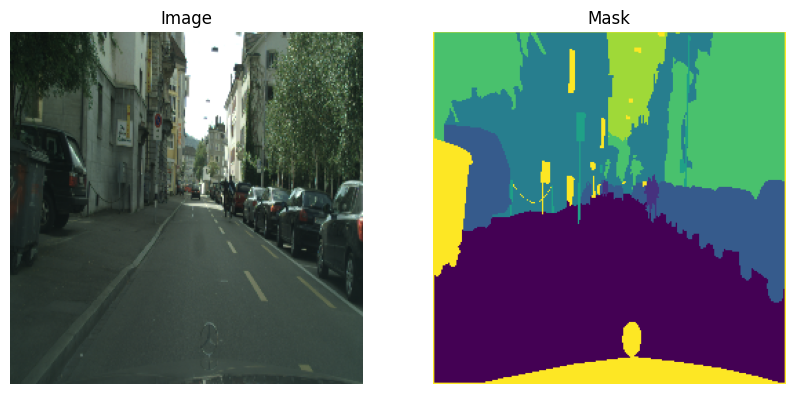

[[7 7 7 ... 7 7 7]
 [7 5 5 ... 5 5 7]
 [7 5 5 ... 5 5 7]
 ...
 [7 0 0 ... 0 0 7]
 [7 0 0 ... 0 0 7]
 [7 7 7 ... 7 7 7]]

Les groupes dans cette image:
  flat: 25322 pixels (38.6%)
  human: 219 pixels (0.3%)
  vehicle: 7137 pixels (10.9%)
  construction: 11676 pixels (17.8%)
  object: 475 pixels (0.7%)
  nature: 12152 pixels (18.5%)
  sky: 2385 pixels (3.6%)
  void: 6170 pixels (9.4%)


In [168]:
for imgs, masks in train_ds.take(1):
  img = imgs[5]
  mask = masks[5]

  plt.figure(figsize=(10, 10))
  ax= plt.subplot(1, 2, 1)
  ax.imshow(img)
  plt.title("Image")
  plt.axis("off")

  ax = plt.subplot(1, 2, 2)
  ax.imshow(mask)
  plt.title("Mask")
  plt.axis("off")

  plt.show()

  unique_classes, counts = np.unique(mask.numpy(), return_counts=True)
  print(mask.numpy())
  print("\nLes groupes dans cette image:")
  for group_id, count in zip(unique_classes, counts):
      percentage = (count / mask.numpy().size) * 100
      print(f"  {ordered_groups[group_id]}: {count} pixels ({percentage:.1f}%)")